<a href="https://colab.research.google.com/github/manikanta-781/crop_yeild_prediction/blob/main/crop_yeild_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv('/content/yield_df.csv')

In [ ]:
df.head()

df.drop('Unnamed: 0',axis=1,inplace=True)

df.shape

df.info()

df.isnull().sum()

df.duplicated().sum()

df.drop_duplicates(inplace=True)

df.duplicated().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28242 entries, 0 to 28241
Data columns (total 7 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Area                           28242 non-null  object 
 1   Item                           28242 non-null  object 
 2   Year                           28242 non-null  int64  
 3   hg/ha_yield                    28242 non-null  int64  
 4   average_rain_fall_mm_per_year  28242 non-null  float64
 5   pesticides_tonnes              28242 non-null  float64
 6   avg_temp                       28242 non-null  float64
dtypes: float64(3), int64(2), object(2)
memory usage: 1.5+ MB


np.int64(0)

In [ ]:
def isStr(obj):
    try:
        float(obj)
        return False
    except:
        return True
to_drop = df[df['average_rain_fall_mm_per_year'].apply(isStr)].index

df = df.drop(to_drop)

df

,Area,Item,Year,hg/ha_yield,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp
0,Albania,Maize,1990,36613,1485.0,121.00,16.37
1,Albania,Potatoes,1990,66667,1485.0,121.00,16.37
2,Albania,"Rice, paddy",1990,23333,1485.0,121.00,16.37
3,Albania,Sorghum,1990,12500,1485.0,121.00,16.37
4,Albania,Soybeans,1990,7000,1485.0,121.00,16.37
...,...,...,...,...,...,...,...
28237,Zimbabwe,"Rice, paddy",2013,22581,657.0,2550.07,19.76
28238,Zimbabwe,Sorghum,2013,3066,657.0,2550.07,19.76
28239,Zimbabwe,Soybeans,2013,13142,657.0,2550.07,19.76
28240,Zimbabwe,Sweet potatoes,2013,22222,657.0,2550.07,19.76


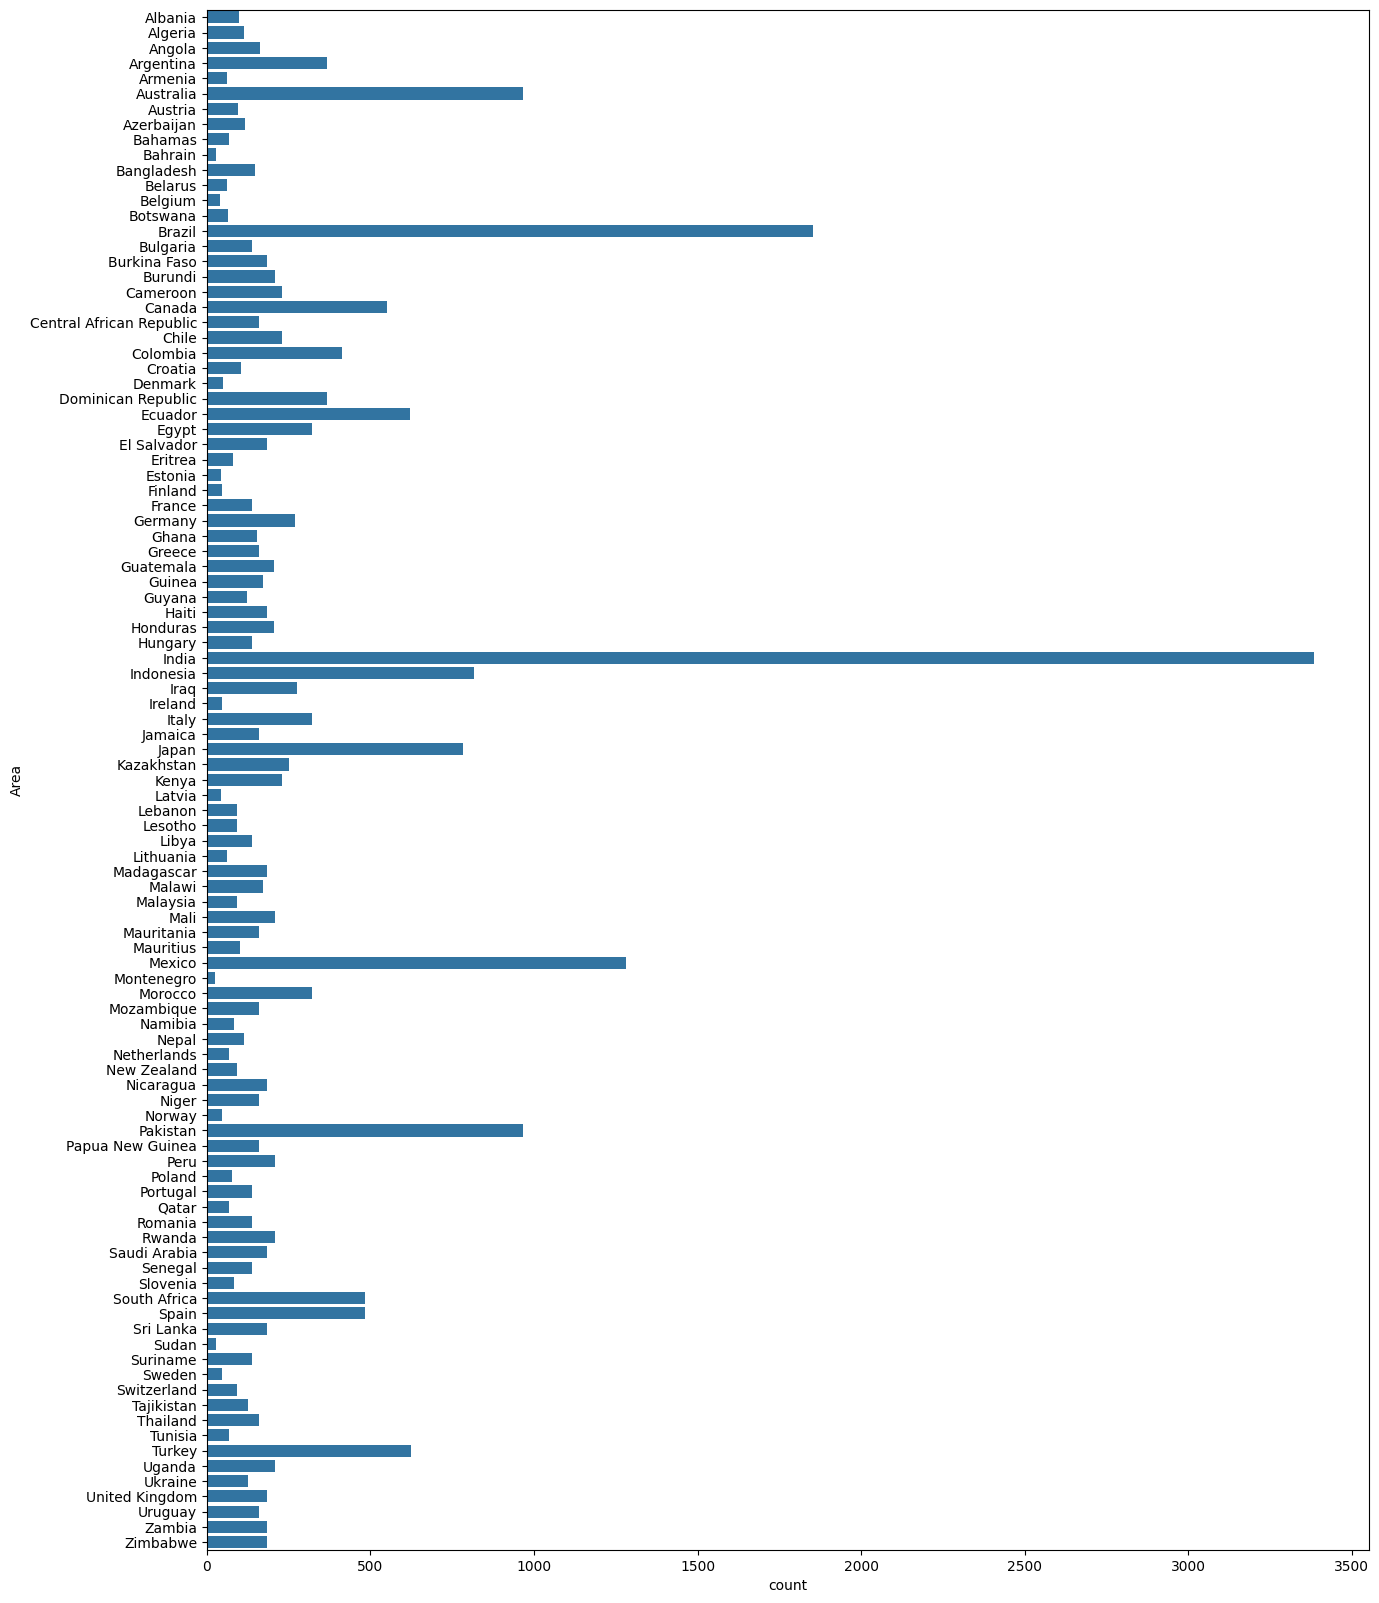

In [ ]:
df['average_rain_fall_mm_per_year'] = df['average_rain_fall_mm_per_year'].astype(np.float64)

len(df['Area'].unique())

plt.figure(figsize=(15,20))
sns.countplot(y=df['Area'])
plt.show()

(df['Area'].value_counts() < 500).sum()

country = df['Area'].unique()
yield_per_country = []
for state in country:
    yield_per_country.append(df[df['Area']==state]['hg/ha_yield'].sum())

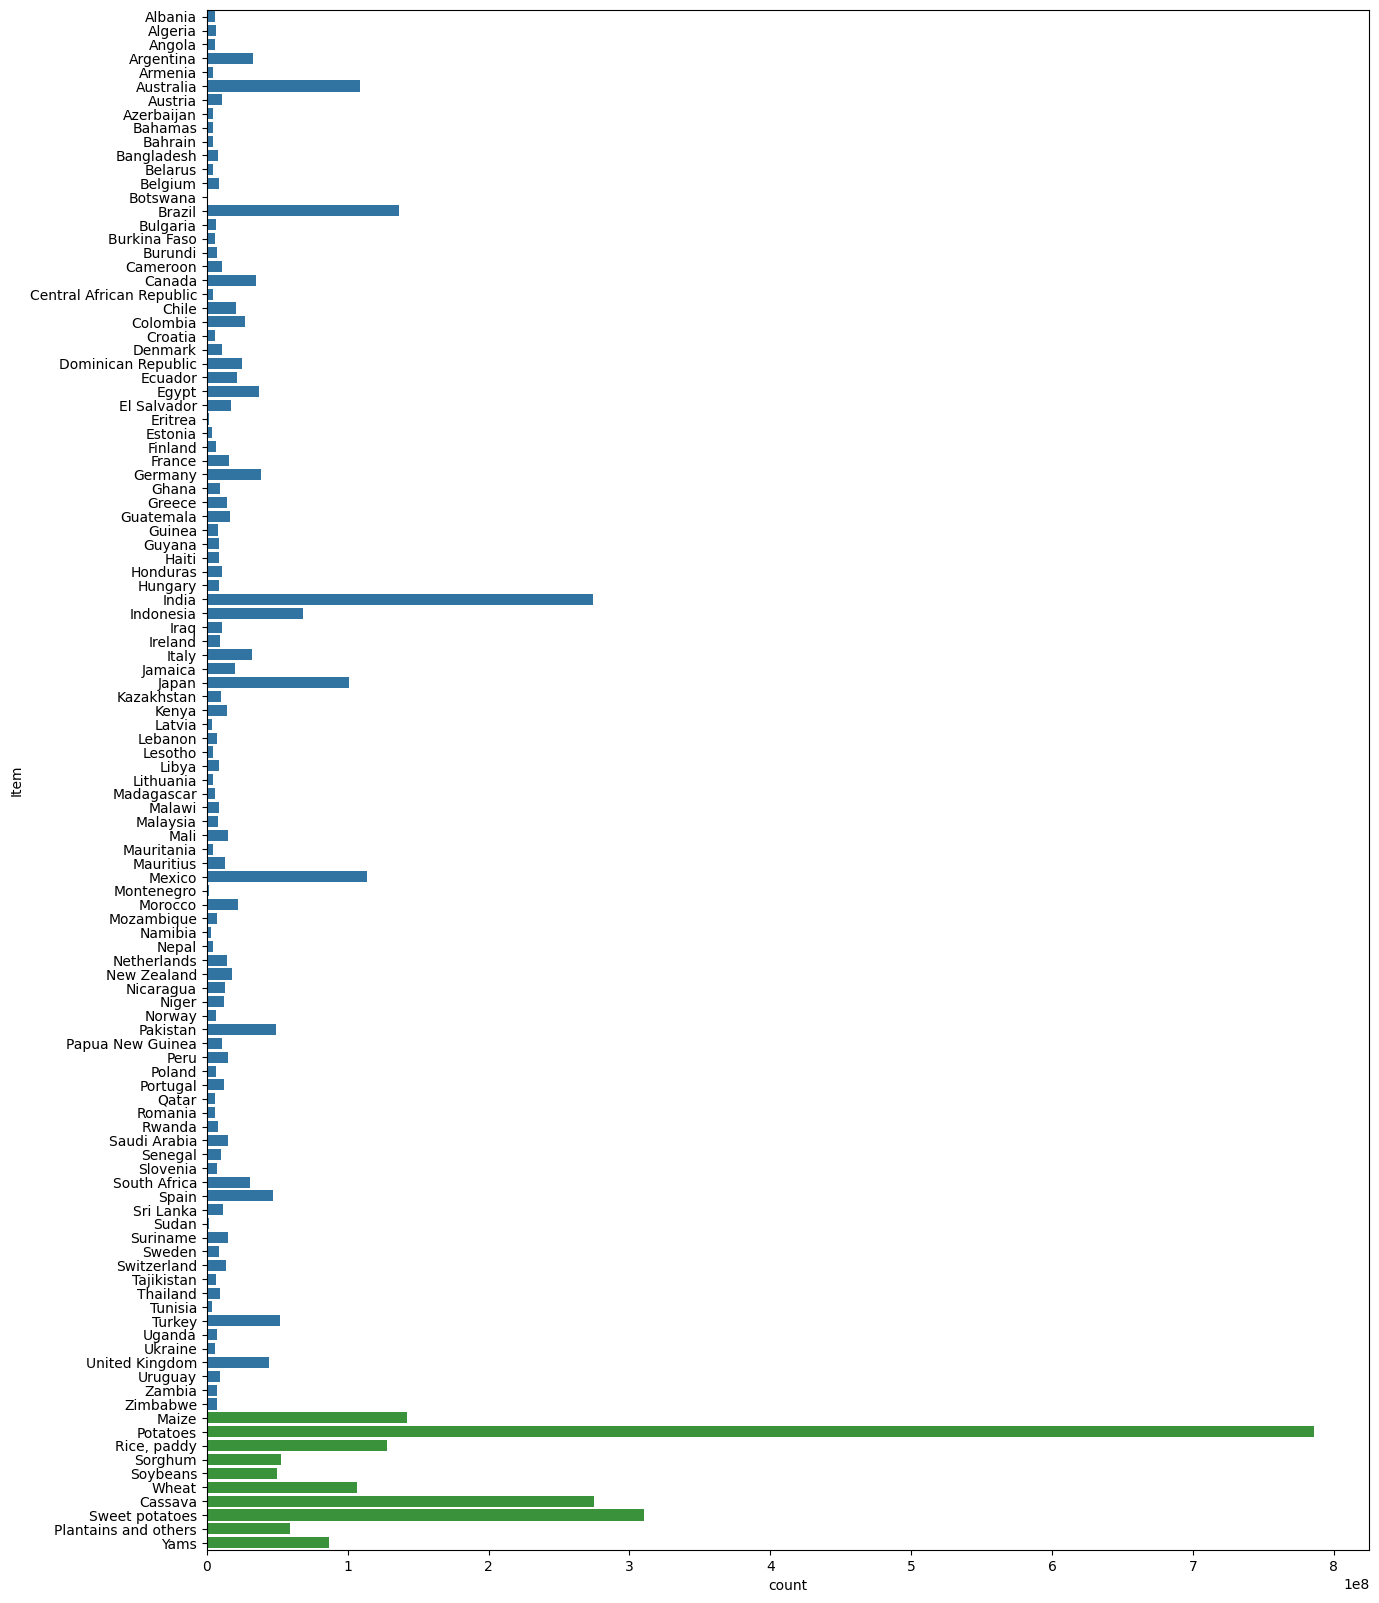

In [ ]:
df['hg/ha_yield'].sum()

yield_per_country

plt.figure(figsize=(15, 20))
sns.barplot(y=country, x=yield_per_country)

sns.countplot(y=df['Item'])

crops = df['Item'].unique()
yield_per_crop = []
for crop in crops:
    yield_per_crop.append(df[df['Item']==crop]['hg/ha_yield'].sum())

sns.barplot(y=crops,x=yield_per_crop)

col = ['Year', 'average_rain_fall_mm_per_year','pesticides_tonnes', 'avg_temp', 'Area', 'Item', 'hg/ha_yield']
df = df[col]
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

In [ ]:
df.head(3)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=0, shuffle=True)

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
ohe = OneHotEncoder(drop='first')
scale = StandardScaler()

preprocesser = ColumnTransformer(
        transformers = [
            ('StandardScale', scale, [0, 1, 2, 3]),
            ('OHE', ohe, [4, 5]),
        ],
        remainder='passthrough'
)

X_train_dummy = preprocesser.fit_transform(X_train)
X_test_dummy = preprocesser.transform(X_test)

preprocesser.get_feature_names_out(col[:-1])

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, explained_variance_score
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse, greater_is_better=False)

# Define cross-validation strategy
cv = KFold(n_splits=5, shuffle=True, random_state=42)

models = {
    'Linear Regression': LinearRegression(),
    'Lasso': Lasso(),
    'Ridge': Ridge(),
    'Decision Tree': DecisionTreeRegressor()
}

In [ ]:
for name, model in models.items():
    mae_scores = cross_val_score(model, X_train_dummy, y_train, scoring='neg_mean_absolute_error', cv=cv)
    r2_scores = cross_val_score(model, X_train_dummy, y_train, scoring='r2', cv=cv)
    rmse_scores = cross_val_score(model, X_train_dummy, y_train, scoring=rmse_scorer, cv=cv)

    print(f"{name}:")
    print(f"  Mean MAE  = {-np.mean(mae_scores):.2f}")
    print(f"  Mean RMSE = {-np.mean(rmse_scores):.2f}")
    print(f"  Mean R²   = {np.mean(r2_scores):.4f}\n")

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'max_depth': [3, 5, 10, 20, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': [None, 'auto', 'sqrt', 'log2']
}

# Initialize the model
dtr = DecisionTreeRegressor(random_state=42)

# GridSearchCV setup
grid_search = GridSearchCV(
    estimator=dtr,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

# Fit to training data
grid_search.fit(X_train_dummy, y_train)

# Best parameters and score
print("Best Parameters:\n", grid_search.best_params_)
print("\nBest MSE Score:", -grid_search.best_score_)

# Use the best model to predict
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test_dummy)

Linear Regression:
  Mean MAE  = 29711.02
  Mean RMSE = 42398.71
  Mean R²   = 0.7487



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1428542936072.832, tolerance: 11797383966.023434
  model = cd_fast.sparse_enet_coordinate_descent(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6479727174241.168, tolerance: 12036120600.563812
  model = cd_fast.sparse_enet_coordinate_descent(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 591902925571.1562, tolerance: 11788815504.741589
  model = cd_fast.sparse_enet_coordinate_descent(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:656: Conve

Lasso:
  Mean MAE  = 29692.48
  Mean RMSE = 42397.85
  Mean R²   = 0.7487

Ridge:
  Mean MAE  = 29643.63
  Mean RMSE = 42398.88
  Mean R²   = 0.7487

Decision Tree:
  Mean MAE  = 4528.27
  Mean RMSE = 14222.39
  Mean R²   = 0.9725

Fitting 5 folds for each of 320 candidates, totalling 1600 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
400 fits failed out of a total of 1600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
400 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.11/dist-packages/sklearn/uti

Best Parameters:
 {'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 5}

Best MSE Score: 177750374.35094


In [ ]:
# Evaluate final model
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
mae = mean_absolute_error(y_test, y_pred_best)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_best))
r2 = r2_score(y_test, y_pred_best)

print("\nFinal Evaluation on Test Set:")
print(f"MAE  = {mae:.2f}")
print(f"RMSE = {rmse:.2f}")
print(f"R²   = {r2:.4f}")

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd  # Import pandas



Final Evaluation on Test Set:
MAE  = 4169.95
RMSE = 12622.04
R²   = 0.9778


<ipython-input-12-1694e6e66f61>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance_df.head(15), x='Importance', y='Feature', palette='viridis')


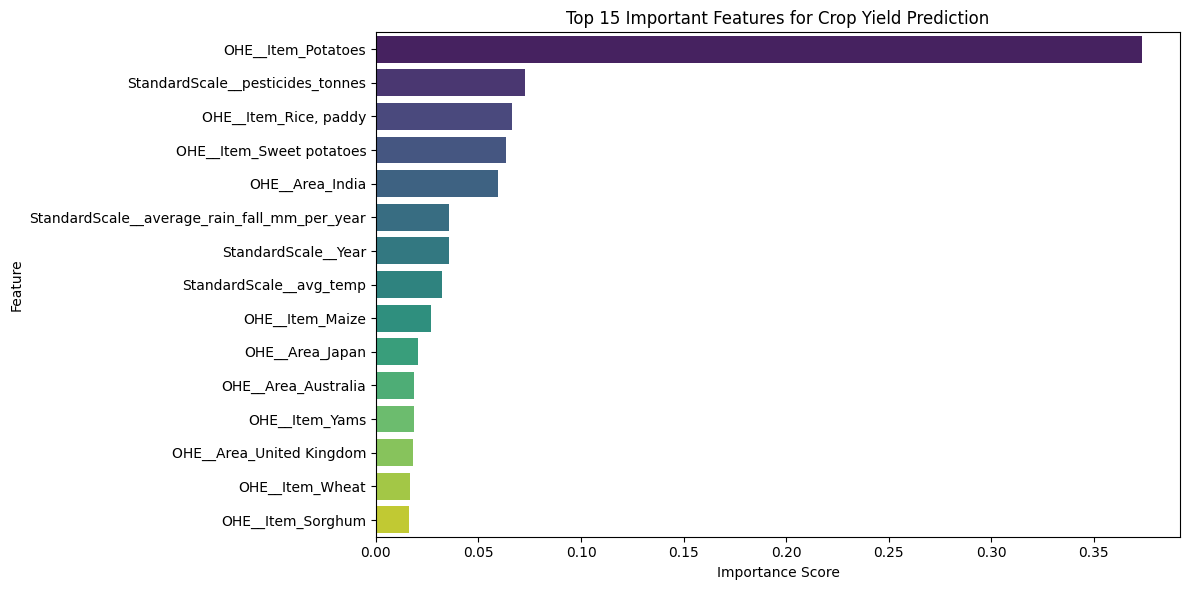

In [ ]:
# Get feature names using get_feature_names_out()
feature_names = preprocesser.get_feature_names_out(col[:-1])

# Get importances from the best decision tree
importances = best_model.feature_importances_

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plotting
plt.figure(figsize=(12, 6))
sns.barplot(data=feature_importance_df.head(15), x='Importance', y='Feature', palette='viridis')
plt.title('Top 15 Important Features for Crop Yield Prediction')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()